In [1]:
# Standard Packages
from torch.utils.data import random_split, DataLoader
import torch
from datetime import datetime
from matplotlib import pyplot as plt
# Custom Packages
from NeuralNetworkModels.SimpleFeedForward import DirectFeedForwardNet
from AntennaDatasets import AntennaDatasetLoaders

# General Settings
torch.manual_seed(42) # Manual seed for sanity
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
CUTS_IN_DATASET = 12

dataset = AntennaDatasetLoaders.ReflectorCutDataset(cuts = CUTS_IN_DATASET,flatten_output = True)

In [3]:
TEST_TRAIN_RATIO = 0.7
BATCH_SIZE = 1
train_len = int(len(dataset)*TEST_TRAIN_RATIO)
train_set, test_set = random_split(dataset, [train_len, len(dataset) - train_len])

train_dataloader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size = BATCH_SIZE, shuffle=True)

In [4]:

#Define model
model = DirectFeedForwardNet(in_features = 3,out_features = 4004,NN = 100)
#Test Forward pass
print(model(torch.randn(2,3).to(device)))

tensor([[-0.0983, -0.0746, -0.0238,  ..., -0.1046, -0.1314, -0.1130],
        [-0.0551, -0.0692, -0.0631,  ..., -0.0532, -0.1000, -0.0336]],
       grad_fn=<AddmmBackward>)


In [5]:
LEARNING_RATE = 4e-3
MOMENTUM = 0.8


criterion = torch.nn.MSELoss()


In [6]:
EPOCHS = int(8e3)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

startTime = datetime.now()
train_loss_array = []
test_loss_array = []
loss_array = []

for epoch in range(EPOCHS):

    epoch_training_loss = 0
    epoch_training_targets = 0
    train_batches = 0
    for input_train_batch, target_train_batch in train_dataloader:
        
        ## Transfer Batch to Device
        input_train_batch = input_train_batch.to(device)
        target_train_batch = target_train_batch.to(device)
        
        prediction = model(input_train_batch)
        
        loss = criterion(input = prediction, target = target_train_batch)
        epoch_training_loss += loss/(target_train_batch.shape[0]*target_train_batch.shape[1])
        train_batches +=1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    
    epoch_test_loss = 0
    epoch_test_targets = 0
    test_batches=0
    with torch.no_grad():
        
        for input_test_batch, target_test_batch in test_dataloader:
            
            # Put thing to device
            input_test_batch = input_test_batch.to(device)
            target_test_batch = target_test_batch.to(device)
            
            
            prediction = model(input_train_batch)
            loss = criterion(input = prediction, target = target_test_batch)
            epoch_test_loss += loss/(target_test_batch.shape[0]*target_test_batch.shape[1])
            test_batches += 1
    
    if epoch%(EPOCHS/10) == 0:
        print('Training Loss',(epoch_training_loss/train_batches).item())
        print('Test Loss',(epoch_test_loss/test_batches).item())



print('Training time:', datetime.now()-startTime)

Training Loss 0.004567678086459637
Test Loss 0.003914696630090475
Training Loss 0.0007376511348411441
Test Loss 0.010336671024560928
Training Loss 0.0004854951112065464
Test Loss 0.008605068549513817


KeyboardInterrupt: 

tensor([[0.0179, 0.4000, 0.0000]])


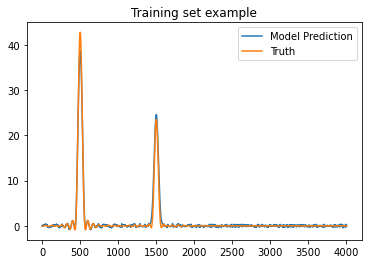

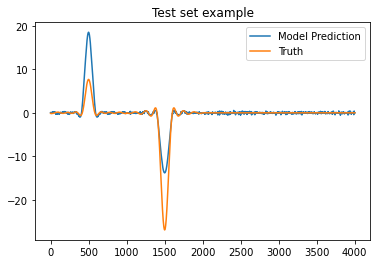

In [19]:
inp, tar = next(iter(train_dataloader)) 
print(inp)
plt.figure()
plt.title('Training set example')
plt.plot(model(inp).flatten().detach(),label = 'Model Prediction')
plt.plot(tar.flatten(),label ='Truth')
plt.legend()

inp, tar = next(iter(test_dataloader)) 
plt.figure()
plt.title('Test set example')
plt.plot(model(inp).flatten().detach(),label = 'Model Prediction')
plt.plot(tar.flatten(),label = 'Truth')
plt.legend()

Loss 15.296945571899414
Loss 14.95227336883545
Loss 8.817069053649902
Loss 0.0440758652985096
Loss 0.00012429896742105484
Loss 3.5023180089410744e-07
Loss 1.127683391111134e-09
Loss 1.0946563794300701e-10
Loss 5.321188628615303e-11
Loss 3.5198371994837885e-11


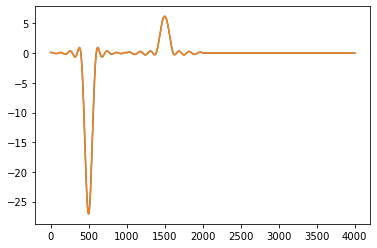

In [16]:
## Test overfitting
EPOCHS = int(2e3)

overFitModel = DirectFeedForwardNet(in_features = 3,out_features = 4004,NN = 100)
optimizer = torch.optim.SGD(overFitModel.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
inp, tar = next(iter(train_dataloader)) 
for epoch in range(EPOCHS):
    prediction = overFitModel(inp)
        
    loss = criterion(input = prediction, target = tar)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%(EPOCHS/10) == 0:
        print('Loss', loss.item())
    
    
plt.plot(overFitModel(inp).flatten().detach())
plt.plot(tar.flatten())

In [ ]:
inputs, classes = next(iter(train_dataloader)) 
print(inputs,classes)